## Julia installation and setup


1 - Disable python syntax highlighting:

 - Tools→Settings→Editor→Code Diagnostics→None

2 - Run code block (Install Julia and packages) below

3 - Runtime→Change runtime type→Runtime type→Julia 1.11.2

4 - If you need to analyze any files, upload them using the Colab files menu on the left: image.png
→
image.png

In [ ]:
#@title Install Julia & packages
#@markdown Installing Julia and packages may take some time. Go grab a coffee.

#@markdown Don't forget to change the runtime type to Julia 1.11.2 when this is done!

%%shell
set -e

JULIA_VERSION="1.11.2"
JULIA_PACKAGES="IJulia BenchmarkTools MolecularEvolution Plots Phylo FASTX"
JULIA_NUM_THREADS=2

if [ -z "$(which julia)" ]; then
    JULIA_VER=$(cut -d '.' -f -2 <<< "$JULIA_VERSION")
    echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
    BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
    URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
    wget -nv "$URL" -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz

    # Check if julia was successfully extracted
    if [ ! -x /usr/local/bin/julia ]; then
        echo "Error: Julia extraction failed or julia executable not found in /usr/local/bin"
        exit 1
    fi

    # Update the PATH variable
    export PATH="/usr/local/bin:$PATH"

    # Install Packages
    JULIA_PACKAGES="$JULIA_PACKAGES"
    for PKG in $(echo $JULIA_PACKAGES); do
        echo "Installing Julia package $PKG..."
        julia -e 'using Pkg; pkg"add '$PKG'"; precompile;' &> /dev/null
    done

    echo "Installing unregistered package CodonMolecularEvolution..."
    julia -e 'using Pkg; pkg"add https://github.com/MurrellGroup/CodonMolecularEvolution.jl"; precompile;' &> /dev/null

    # Install kernel and rename it to "julia"
    echo "Installing IJulia kernel..."
    julia -e 'using IJulia; IJulia.installkernel("julia-1.11", env=Dict(
        "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'

    # Capture the kernel directory using command substitution
    KERNEL_DIR=$(julia -e 'using IJulia; print(IJulia.kerneldir())')

    # Capture the kernel name, ensuring it exists and is of the form julia-*
    KERNEL_NAME=$(ls -d "$KERNEL_DIR"/julia-*)
fi

echo "Julia installation and setup completed."

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling UnitfulExt [0e51ec96-f580-5f12-a625-1297083d7970] (cache misses: wrong dep version loaded (2))


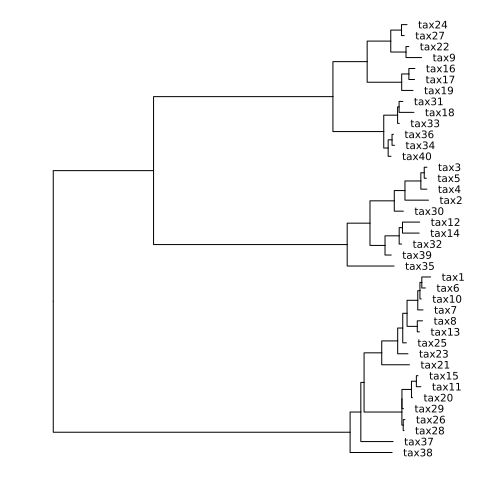

In [3]:
#@title Load packages and test: you should see a tree
using Pkg, MolecularEvolution, Plots, Phylo, FASTX, CodonMolecularEvolution

#First simulate a tree, using a coalescent process
tree = sim_tree(40, 10.0, 10.0)
plot(get_phylo_tree(tree), size = (500,500))

In [104]:
#Load your codon sequence alignment, and your tree:
seqnames, seqs = read_fasta("Ace2_with_bat.fasta")
treestring = readlines("Ace2_with_bat.tre")[1]

"(((((bat_Hipposideros_galeritus:0.026377853000000007,(bat_Hipposideros_pratti:0.003788874999999997,(bat_Hipposideros_armiger:4.999999997368221E-9,XM_019667391_Hipposideros_armiger:4.999999997368221E-9):0.0033962590000000126):0.018221397):0.037165891000000006,((bat_Rhinolophus_ferrumequinum:4.999999997368221E-9,XM_033107295_Rhinolophus_fer" ⋯ 13818 bytes ⋯ "6308):0.013114243999999997):0.043430841):0.004149167000000009):0.015223636999999984):0.02003517499999999):0.011080140000000016):0.01985971799999997):0.004591357000000018):0.006358849):0.005341892000000015):0.0029244019999999926):0.009960648999999988):0.01014493700000002):0.005963518000000001):0.0025803929999999864):0.011037780000000025);"

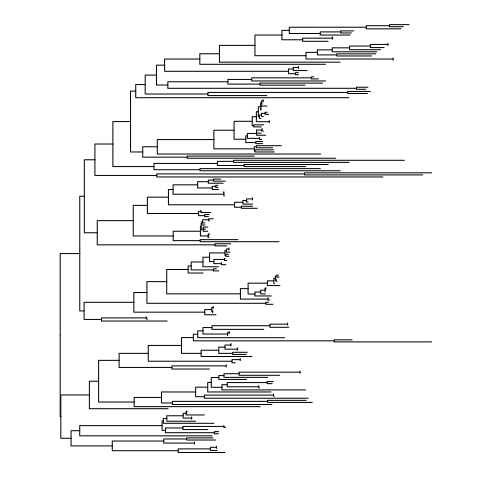

In [117]:
#Viz your tree:
plot(get_phylo_tree(gettreefromnewick(treestring, FelNode)), showtips = false, size = (500,500))

In [53]:
#Run a FUBAR analysis (this will export files/plots you can download in the left panel)
outdir = "fubar"
!(outdir in readdir()) && mkdir(outdir)
fgrid = alphabetagrid(seqnames, seqs, treestring);
fubar_df, params = FUBAR(fgrid, outdir*"/fubarACE2")

Step 1: Initialization.
Step 2: Optimizing global codon model parameters.
Optimized single α,β LL=-66072.5653180695 with α=1.9408755336541665 and β=0.7757102166805467.
Step 3: Calculating conditional likelihoods.
Step 4: Model fitting.
Step 5: Tabulating results and saving plots.
19 sites with positive selection above threshold.
487 sites with purifying selection above threshold.


(835×5 DataFrame
 Row │ site   positive_posterior  purifying_posterior  beta_pos_mean  alpha_pos_mean 
     │ Int64  Float64             Float64              Float64        Float64        
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │     1         0.00564091            0.985948        0.0126755        1.42784
   2 │     2         0.0807406             0.74111         0.348184         0.652525
   3 │     3         0.674128              0.106659        0.519327         0.331169
   4 │     4         5.12413e-5            0.998737        0.218889         1.12802
   5 │     5         0.916963              0.00503914      0.922504         0.332656
   6 │     6         0.00929433            0.981231        0.0227716        1.47459
   7 │     7         0.686157              0.175065        0.275991         0.168336
   8 │     8         0.245816              0.401255        0.509702         0.585186
   9 │     9         0.0118501             0.964

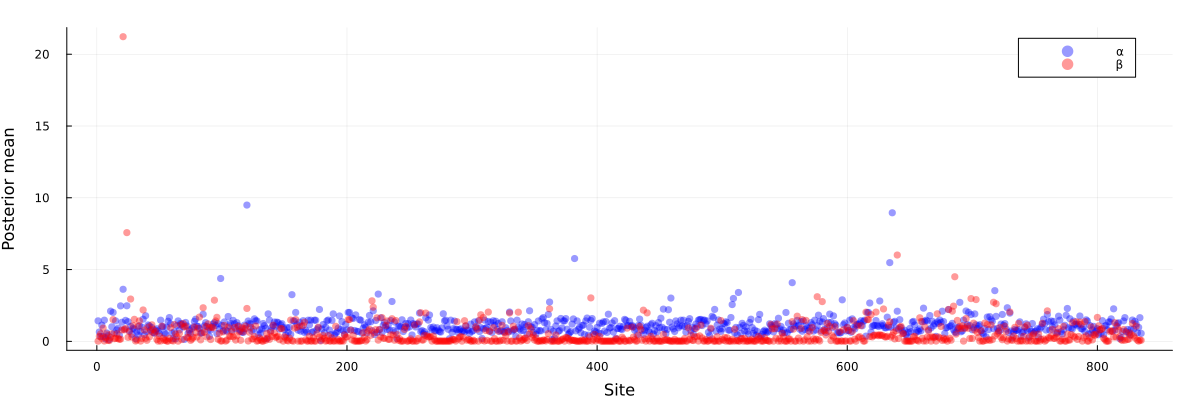

In [84]:
#Plot the posterior means of alpha and beta
scatter(fubar_df.site, fubar_df.alpha_pos_mean,
        alpha = 0.4, msw = 0, xlabel = "Site", ylabel = "Posterior mean",
        color = "blue", label = "α", size = (1200, 400), margins = 5Plots.mm)
scatter!(fubar_df.site, fubar_df.beta_pos_mean,
        alpha = 0.4, msw = 0, color = "red", label = "β")

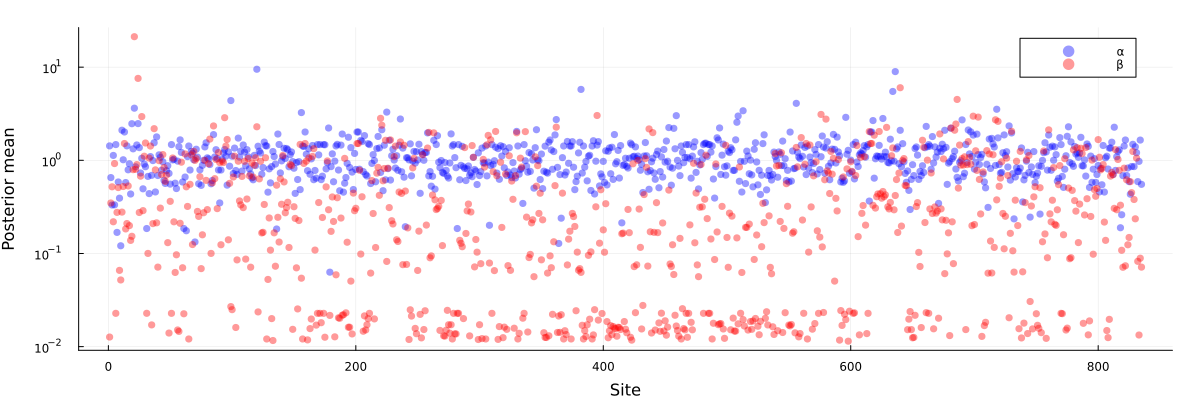

In [85]:
#hmmm lets try that with a log scale Y axis
scatter(fubar_df.site, fubar_df.alpha_pos_mean,
        alpha = 0.4, msw = 0, xlabel = "Site", ylabel = "Posterior mean",
        color = "blue", label = "α", size = (1200, 400), margins = 5Plots.mm)
scatter!(fubar_df.site, fubar_df.beta_pos_mean,
        alpha = 0.4, msw = 0, color = "red", label = "β",
        yscale = :log10, yticks = [0.01, 0.1, 1.0, 10.0])

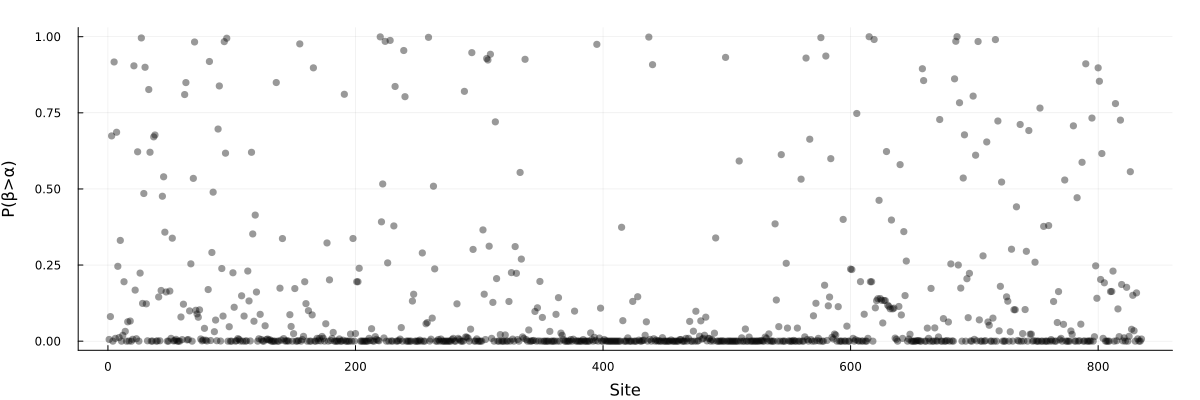

In [88]:
#Plot the posterior probs of β>α
scatter(fubar_df.site, fubar_df.positive_posterior,
        xlabel = "Site", ylabel = "P(β>α)", color = "black",
        alpha = 0.4, msw = 0, label = :none, size = (1200, 400), margins = 5Plots.mm)

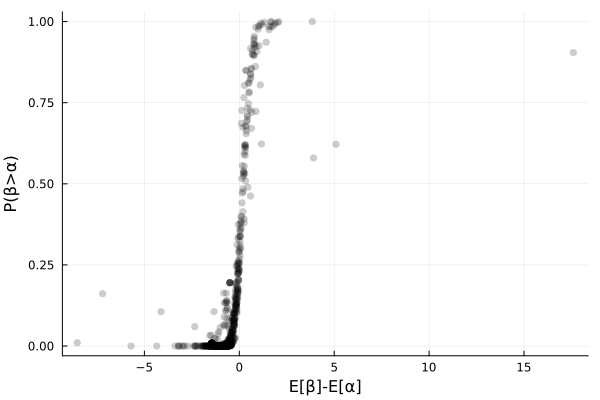

In [89]:
#How does that correlate with the difference in the posterior mean E[β]-E[α]?
scatter(fubar_df.beta_pos_mean .- fubar_df.alpha_pos_mean, fubar_df.positive_posterior,
        xlabel = "E[β]-E[α]", ylabel = "P(β>α)", color = "black",
        alpha = 0.2, msw = 0, label = :none)

In [62]:
#If you want to re-export the processed results using different thresholds:
FUBAR_tabulate_from_θ(params.θ, fgrid, outdir*"/fubar_retabACE2", posterior_threshold = 0.99)

Step 5: Tabulating results and saving plots.
10 sites with positive selection above threshold.
375 sites with purifying selection above threshold.


Row,site,positive_posterior,purifying_posterior,beta_pos_mean,alpha_pos_mean
,Int64,Float64,Float64,Float64,Float64
1,1,0.00564091,0.985948,0.0126755,1.42784
2,2,0.0807406,0.74111,0.348184,0.652525
3,3,0.674128,0.106659,0.519327,0.331169
4,4,5.12413e-5,0.998737,0.218889,1.12802
5,5,0.916963,0.00503914,0.922504,0.332656
6,6,0.00929433,0.981231,0.0227716,1.47459
7,7,0.686157,0.175065,0.275991,0.168336
8,8,0.245816,0.401255,0.509702,0.585186
9,9,0.0118501,0.964818,0.0658509,0.39224


In [63]:
#Run approximate frequentist inference (similar to Hyphy's FEL, but calculated from an interpolated FUBAR grid):
fife_df = fifeFUBAR(fgrid, outdir*"/fifeACE2")

Row,p_value,LRS,LL_alt,α_alt,β_alt,LL_null,αβ_null,sel,site
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String,Int64
1,0.999984,4.08799e-10,-3.87393,0.00235094,0.00235093,-3.87393,0.00235093,,1
2,0.63102,0.23068,-59.151,0.460387,0.331519,-59.2663,0.378981,,2
3,0.142091,2.15516,-80.6604,0.18286,0.510086,-81.738,0.392244,,3
4,0.00168701,9.86229,-71.303,1.16861,0.196522,-76.2341,0.466899,Purifying,4
5,0.00734459,7.1867,-95.0044,0.183838,0.945472,-98.5978,0.670504,Positive,5
6,0.999993,8.65441e-11,-4.82543,0.00235094,0.00235093,-4.82543,0.00235093,,6
7,0.230195,1.43965,-45.8046,0.0867771,0.264251,-46.5244,0.1945,,7
8,0.712863,0.135434,-66.7744,0.381488,0.486594,-66.8421,0.455315,,8
9,0.140704,2.17024,-35.087,0.247347,0.0398838,-36.1721,0.124082,,9


In [100]:
#Pull out only the sites with p<0.01 for positive selection:
fife_df[(fife_df.sel .== "Positive") .& (fife_df.p_value .< 0.01), :]

Row,p_value,LRS,LL_alt,α_alt,β_alt,LL_null,αβ_null,sel,site
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String,Int64
1,0.00734459,7.1867,-95.0044,0.183838,0.945472,-98.5978,0.670504,Positive,5
2,0.00144375,10.1491,-198.786,0.91941,3.15608,-203.86,2.27348,Positive,27
3,0.00068117,11.5399,-116.294,0.00235093,1.03703,-122.064,0.684343,Positive,70
4,0.00884035,6.8548,-248.825,1.29325,2.94994,-252.253,2.34224,Positive,94
5,0.000702872,11.4816,-150.569,0.37041,1.79252,-156.309,1.2092,Positive,96
6,0.00327613,8.64693,-141.796,0.19994,1.55337,-146.12,1.18728,Positive,155
7,0.000121173,14.7743,-195.481,0.557392,2.93887,-202.869,2.11922,Positive,220
8,0.00553096,7.6971,-151.979,0.413075,1.76723,-155.827,1.38145,Positive,224
9,0.00461582,8.02413,-168.327,0.41492,1.77885,-172.339,1.39511,Positive,228
